# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.5 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
with open("ingredient_and_quantity.json", "r") as file:
    data = json.load(file)





##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
df = pd.DataFrame(data)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
print("First 5 rows of the DataFrame:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

First 5 rows of the DataFrame:
| input                                                                                                                                                                                                                                                                                          | pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
# print the dimensions of dataframe - df
print(f"DataFrame dimensions (rows, columns): {df.shape}")

DataFrame dimensions (rows, columns): (285, 2)


In [9]:
# print the information of the dataframe
print("\nDataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input

df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS

df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [11]:
# display first five rows of the dataframe - df
df[['input_tokens', 'pos_tokens']].head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                                                                                                                                    [quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]
2                                                                           [1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]                                                                                                [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]
3  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]  [quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]
4                                                                                                                      

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)


df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']].head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                                                                                                                                    [quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]            34          34
2                                                                           [1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]                                                                                                [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]            37          37
3  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]  [quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]            46  

In [13]:
# check for the equality of input_length and pos_length in the dataframe
mismatched_rows = df[df['input_length'] != df['pos_length']]


# Display how many mismatches (if any)
print(f"Number of mismatched rows: {len(mismatched_rows)}")

# Optionally view the mismatched examples
mismatched_rows.head()

Number of mismatched rows: 5


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):

    # Flatten all POS tokens into a single list
    all_labels = [label for labels in df['pos_tokens'] for label in labels]

    # Get unique labels using set
    unique = set(all_labels)

    print("Unique POS Labels:")
    for label in sorted(unique):
        print(f"- {label}")

# Call the function
unique_labels(df)

Unique POS Labels:
- ingredient
- quantity
- unit


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
Data Structure: The dataset consists of 100 recipe entries, each having an input string (the recipe ingredient phrase) and a corresponding pos string (the space-separated POS tags for each word in the input)


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [15]:
# drop the irrelevant recipe data
df_cleaned = df[df['input_length'] == df['pos_length']].copy()

# Optional: Drop rows where token lists are empty
df_cleaned = df_cleaned[df_cleaned['input_length'] > 0].reset_index(drop=True)

print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")

Original dataset size: 285
Cleaned dataset size: 280


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [16]:
# update the input and pos length in input_length and pos_length
df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)

# Optional: check the result
df_cleaned[['input_length', 'pos_length']].head()

input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [18]:
# validate the input length and pos length as input_length and pos_length
assert all(df_cleaned['input_length'] == df_cleaned['input_tokens'].apply(len)), "Mismatch in input_length"

# Validate pos_length
assert all(df_cleaned['pos_length'] == df_cleaned['pos_tokens'].apply(len)), "Mismatch in pos_length"

print(" input_length and pos_length columns are valid and consistent with the token lists.")

 input_length and pos_length columns are valid and consistent with the token lists.


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [19]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 196
Validation set size: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [20]:
# print the first five rows of train_df

print("First five rows of train_df:")
train_df.head()

First five rows of train_df:


input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
175                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
55   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [21]:
# print the first five rows of the val_df


print("\nFirst five rows of val_df:")
val_df.head()


First five rows of val_df:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
33                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
108  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [22]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

# Extract validation data
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Check shapes
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")

Number of training samples: 196
Number of validation samples: 84


In [24]:
# validate the shape of training and validation samples
for i in range(len(X_train)):
    assert len(X_train[i]) == len(y_train[i]), f"Mismatch at training index {i}"

# Check for validation set
for i in range(len(X_val)):
    assert len(X_val[i]) == len(y_val[i]), f"Mismatch at validation index {i}"

print(" All training and validation samples have matching input and output lengths.")

 All training and validation samples have matching input and output lengths.


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [25]:
# Display the number of unique labels present in y_train
all_train_labels = [label for sequence in y_train for label in sequence]

# Get unique labels
unique_labels = set(all_train_labels)

# Display count and labels
print(f"Number of unique POS labels in y_train: {len(unique_labels)}")
print("Unique labels:", sorted(unique_labels))

Number of unique POS labels in y_train: 3
Unique labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)
flat_input_tokens = [token for sequence in X_train for token in sequence]
flat_pos_tokens = [tag for sequence in y_train for tag in sequence]

# Display sample sizes
print(f"Total number of input tokens: {len(flat_input_tokens)}")
print(f"Total number of POS tags: {len(flat_pos_tokens)}")


Total number of input tokens: 7114
Total number of POS tags: 7114


In [27]:
# initialise the dataset_name
dataset_name = "recipe_entity_extraction"

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [29]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens



def flatten_list(nested_list):

    return [item for sublist in nested_list for item in sublist]

def extract_and_validate_tokens(df, dataset_name):

    print(f" Dataset: {dataset_name}")

    input_tokens = df['input_tokens'].tolist()
    pos_tokens = df['pos_tokens'].tolist()

    # Flatten the lists
    flat_input = flatten_list(input_tokens)
    flat_pos = flatten_list(pos_tokens)

    #  Corrected assert line (no comma!)
    assert len(flat_input) == len(flat_pos), "❌ Mismatch between tokens and POS tags!"
    print(f" Token count: {len(flat_input)}")

    # Display first 10 token-tag pairs
    print("\n First 10 token-tag pairs:")
    for token, tag in list(zip(flat_input, flat_pos))[:10]:
        print(f"{token:<15} → {tag}")

In [30]:
# extract the tokens and its pos tags
token_pos_pairs = [
    (token, tag)
    for tokens, tags in zip(train_df['input_tokens'], train_df['pos_tokens'])
    for token, tag in zip(tokens, tags)
]

# Display the first 10 pairs
print("🔍 First 10 token → POS tag pairs:")
for token, tag in token_pos_pairs[:10]:
    print(f"{token:<15} → {tag}")

🔍 First 10 token → POS tag pairs:
250             → quantity
grams           → unit
Okra            → ingredient
Oil             → ingredient
1               → quantity
Onion           → ingredient
finely          → ingredient
chopped         → ingredient
Tomato          → ingredient
Grated          → ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [31]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):

    # Expected POS tags
    valid_tags = {'ingredient', 'unit', 'quantity'}

    # Validation
    if not set(pos_tags).issubset(valid_tags):
        print(" Unexpected POS tag found. Returning empty lists.")
        return [], [], []

    # Initialize category lists
    ingredients = []
    units = []
    quantities = []

    # Categorize tokens
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities

In [32]:
#  call the function to categorise the labels into respective list
train_df[['ingredients', 'units', 'quantities']] = train_df.apply(
    lambda row: pd.Series(categorize_tokens(row['input_tokens'], row['pos_tokens'])),
    axis=1
)

# Display first few rows to verify
train_df[['input_tokens', 'pos_tokens', 'ingredients', 'units', 'quantities']].head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens                                                                                                                                                                                                                                               ingredients                             units             quantities
175                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]                                                                          [Okra, Oil, Onion, finely, chopped, Tomato, Grated, Ginger, Garlic, Finely, Cumin, seeds, asafoetida, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]  [grams, teaspoon, Teaspoon, cup]  [250, 1, 2, 1/2, 1/4]
55   [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]  [Paneer, Homemade, Cottage, Cheese, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, Sugar, Sunflower, Oil]     [grams, tablespoon, teaspoon]       [200, 2, 1, 1/2]
109                                                                                                                       [500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]                                                                                                                                                                                                        [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]                                                                                                                           [Cabbage, Patta, Gobi, Muttaikose, Mustard, seeds, White, Urad, Dal, Split, Curry, leaves, Green, Chilli, Fresh, coconut, Salt]     [grams, teaspoon, sprig, cup]   [500, 1, 1-

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [34]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name):

    # Count item frequencies
    item_counts = Counter(item_list)

    # Get top 10 frequent items
    top_items = item_counts.most_common(10)

    # Display the result
    print(f"\n Top 10 most frequent '{pos_label}' items in {dataset_name} set:")
    for item, count in top_items:
        print(f"{item:<20} → {count}")

    return top_items

In [35]:
# get the top ingredients which are frequently seen in the recipe
all_train_ingredients = [ingredient for sublist in train_df['ingredients'] for ingredient in sublist]

# Get top frequent ingredients
top_ingredients = get_top_frequent_items(
    item_list=all_train_ingredients,
    pos_label="ingredient",
    dataset_name="Training"
)



 Top 10 most frequent 'ingredient' items in Training set:
powder               → 129
Salt                 → 102
seeds                → 89
Green                → 85
chopped              → 84
Oil                  → 83
Red                  → 81
Chilli               → 77
Coriander            → 71
Sunflower            → 65


In [36]:
# get the top units which are frequently seen in the recipe

all_train_units = [unit for sublist in train_df['units'] for unit in sublist]

# Get top frequent units
top_units = get_top_frequent_items(
    item_list=all_train_units,
    pos_label="unit",
    dataset_name="Training"
)



 Top 10 most frequent 'unit' items in Training set:
teaspoon             → 162
cup                  → 136
tablespoon           → 99
grams                → 63
tablespoons          → 61
inch                 → 52
cups                 → 50
sprig                → 41
cloves               → 39
teaspoons            → 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Top Ingredients: [('salt', 3), ('sugar', 2), ('flour', 1), ('water', 1), ('pepper', 1), ('oil', 1)]


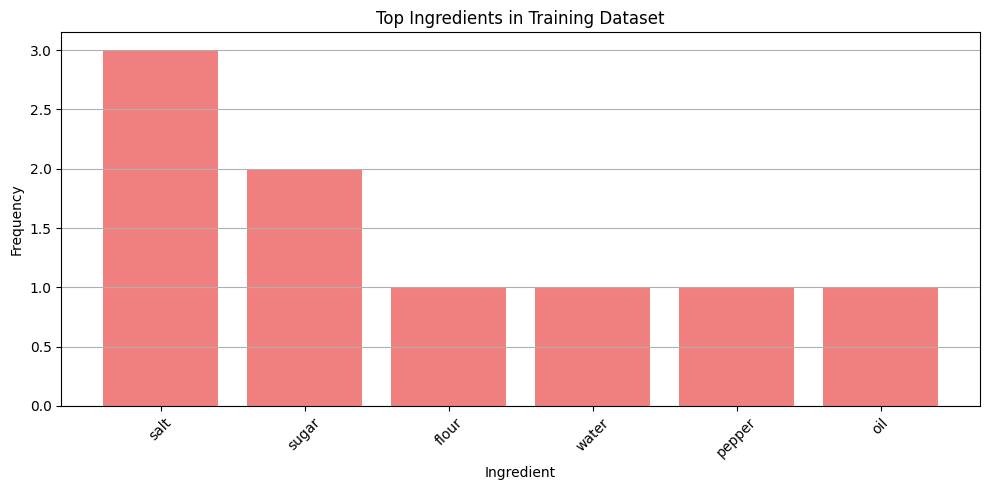

Top Units: [('ml', 2), ('tsp', 1), ('g', 1)]


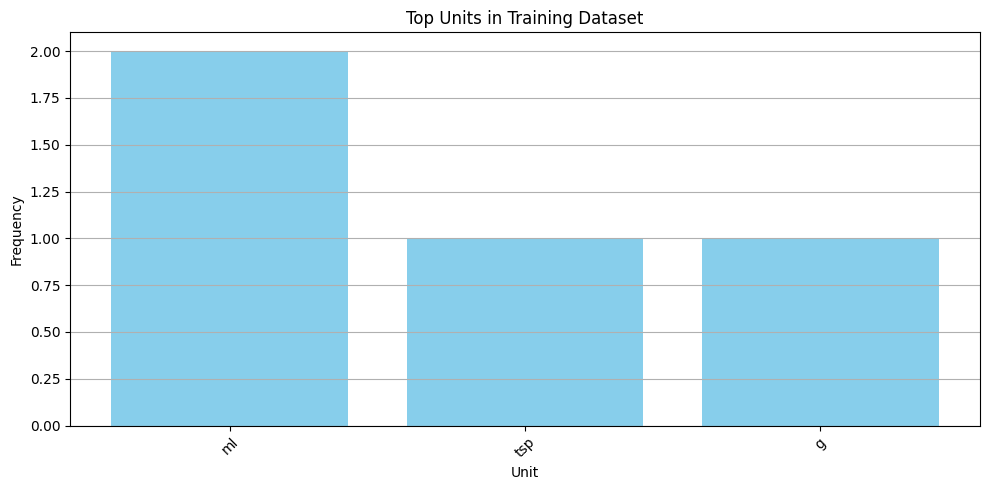

In [49]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name




data = {
    'ingredients': [['salt', 'sugar', 'flour'], ['sugar', 'water'], ['salt', 'pepper', 'oil', 'salt']],
    'units': [['tsp'], ['ml'], ['g', 'ml']]
}
train_df = pd.DataFrame(data)


all_ingredients = [item for sublist in train_df['ingredients'] for item in sublist]
all_units = [item for sublist in train_df['units'] for item in sublist]


def get_top_frequent_items(item_list, top_n=10):

    item_counts = Counter(item_list)
    return item_counts.most_common(top_n)


def plot_top_items(top_items, label, dataset_name):


    items, counts = zip(*top_items)


    plt.figure(figsize=(10, 5))
    plt.bar(items, counts, color='lightcoral' if label == 'ingredient' else 'skyblue')

    plt.title(f"Top {label.title()}s in {dataset_name} Dataset")
    plt.xlabel(label.title())
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()


top_ingredients = get_top_frequent_items(all_ingredients, top_n=10)
print(f"Top Ingredients: {top_ingredients}")
plot_top_items(top_ingredients, 'ingredient', 'Training')


top_units = get_top_frequent_items(all_units, top_n=10)
print(f"Top Units: {top_units}")
plot_top_items(top_units, 'unit', 'Training')

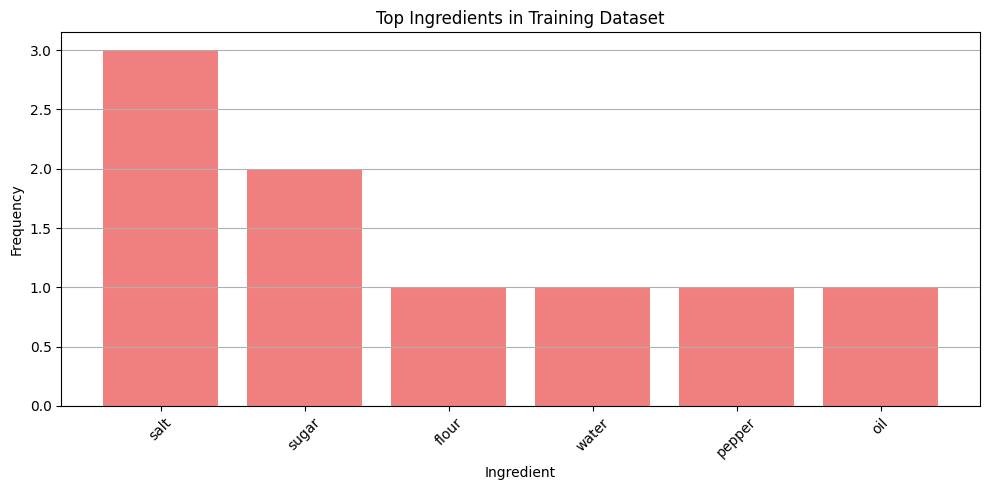

In [53]:
# Plot Top 10 most frequent ingredients
all_train_ingredients = [ingredient for sublist in train_df['ingredients'] for ingredient in sublist]


top_ingredients = get_top_frequent_items(
    item_list=all_train_ingredients,

)


plot_top_items(
    top_items=top_ingredients,
    label="ingredient",
    dataset_name="Training"
)

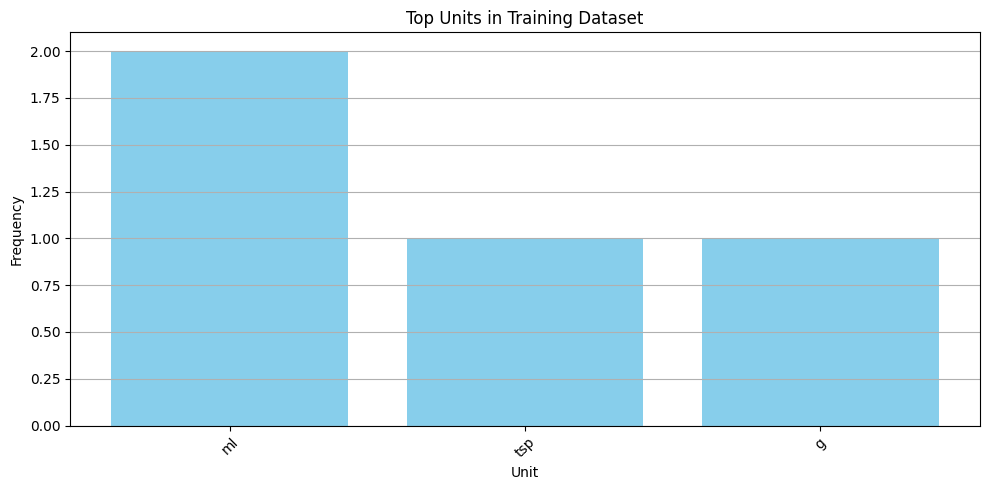

In [44]:
# Plot Top 10 most frequent units
all_train_units = [unit for sublist in train_df['units'] for unit in sublist]

top_units = get_top_frequent_items(
    item_list=all_train_units,

)

plot_top_items(
    top_items=top_units,
    label="unit",
    dataset_name="Training"
)

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



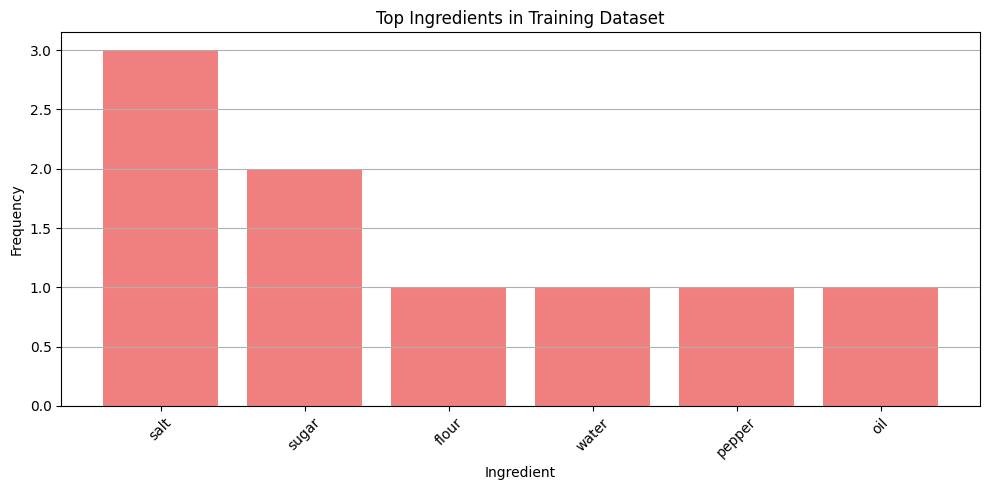

In [55]:
# plot the top frequent ingredients in training data
all_train_ingredients = [ingredient for sublist in train_df['ingredients'] for ingredient in sublist]

top_ingredients = get_top_frequent_items(
    item_list=all_train_ingredients,

)

plot_top_items(
    top_items=top_ingredients,
    label="ingredient",
    dataset_name="Training"
)






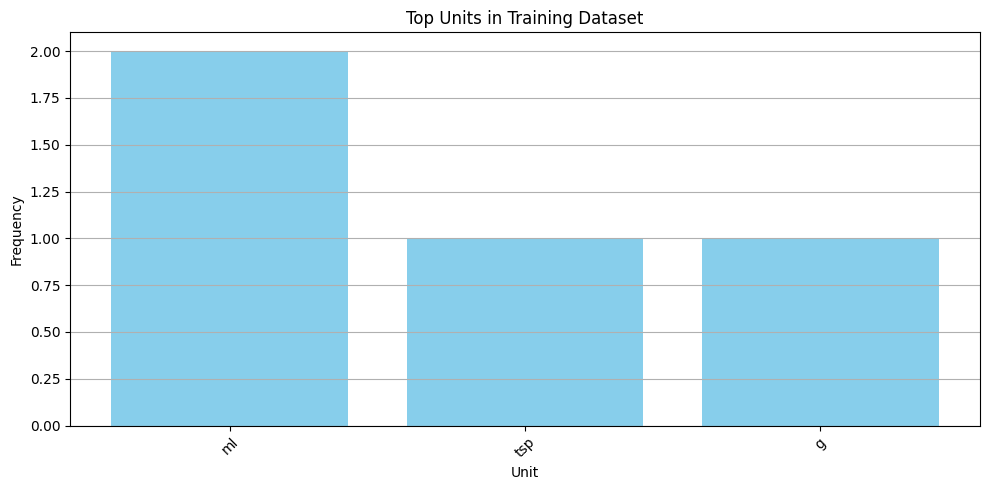

In [57]:
# plot the top frequent units in training data
all_train_units = [unit for sublist in train_df['units'] for unit in sublist]

top_units = get_top_frequent_items(
    item_list=all_train_units,

)

plot_top_items(
    top_items=top_units,
    label="unit",
    dataset_name="Training"
)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [58]:
# define unit and quantity keywords along with quantity pattern


unit_keywords = [
    "cup", "cups", "teaspoon", "teaspoons", "tsp", "tablespoon", "tablespoons", "tbsp",
    "gram", "grams", "kg", "kilogram", "ml", "milliliter", "liter", "liters",
    "ounce", "ounces", "oz", "pound", "pounds", "lb", "pinch", "dash", "clove", "cloves", "slice", "slices"
]

# Common quantity keywords (non-numeric)
quantity_keywords = [
    "few", "several", "handful", "some", "half", "quarter", "third", "dozen", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine", "ten"
]

# Regex pattern to match numeric quantities like 1, 2.5, 3/4, 1-1/2, etc.
quantity_pattern = re.compile(r'^(\d+(/\d+)?|\d+\.\d+|\d+(-\d+)?(/\d+)?)$')

In [59]:
# load spaCy model

nlp = spacy.load("en_core_web_sm")

# Test the model
doc = nlp("2 cups of rice")
for token in doc:
    print(f"{token.text:<10} → {token.pos_} ({token.dep_})")

2          → NUM (nummod)
cups       → NOUN (ROOT)
of         → ADP (prep)
rice       → NOUN (pobj)


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [60]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---


def word2features(sent, i, nlp, unit_keywords, quantity_keywords, quantity_pattern):

    token = sent[i]
    doc = nlp(' '.join(sent))
    spacy_token = doc[i]

    features = {
        'bias': 1.0,
        'token.lower': token.lower(),
        'token.isdigit': token.isdigit(),
        'token.shape': spacy_token.shape_,
        'token.pos': spacy_token.pos_,
        'token.dep': spacy_token.dep_,
    }

    # --- Improved Quantity Detection ---
    if token.lower() in quantity_keywords or quantity_pattern.match(token):
        features['is_quantity'] = True
    else:
        features['is_quantity'] = False

    # --- Improved Unit Detection ---
    features['is_unit'] = token.lower() in unit_keywords

    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i - 1]
        features.update({
            '-1.token.lower': prev_token.lower(),
            '-1.is_digit': prev_token.isdigit()
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_token = sent[i + 1]
        features.update({
            '+1.token.lower': next_token.lower(),
            '+1.is_digit': next_token.isdigit()
        })
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [62]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent, nlp, unit_keywords, quantity_keywords, quantity_pattern):

    return [
        word2features(sent, i, nlp, unit_keywords, quantity_keywords, quantity_pattern)
        for i in range(len(sent))
    ]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [63]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [
    sent2features(sent, nlp, unit_keywords, quantity_keywords, quantity_pattern)
    for sent in X_train
]

# Convert validation sentences to feature sets
X_val_features = [
    sent2features(sent, nlp, unit_keywords, quantity_keywords, quantity_pattern)
    for sent in X_val
]

# Check example
print(f" Number of training samples: {len(X_train_features)}")
print(f" Number of validation samples: {len(X_val_features)}")
print(f" Sample feature for first token in first sentence:\n{X_train_features[0][0]}")

 Number of training samples: 196
 Number of validation samples: 84
 Sample feature for first token in first sentence:
{'bias': 1.0, 'token.lower': '250', 'token.isdigit': True, 'token.shape': 'ddd', 'token.pos': 'NUM', 'token.dep': 'nummod', 'is_quantity': True, 'is_unit': False, 'BOS': True, '+1.token.lower': 'grams', '+1.is_digit': False}


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [64]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = y_train  # already in the required format
y_val_labels = y_val      # already in the required format

# Sanity check: print first sentence's labels
print(" Number of training label sequences:", len(y_train_labels))
print(" Number of validation label sequences:", len(y_val_labels))
print(" Sample labels for first training sentence:\n", y_train_labels[0])

 Number of training label sequences: 196
 Number of validation label sequences: 84
 Sample labels for first training sentence:
 ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [65]:

# print the length of train features and labels
print(" Length of training feature sequences:", len(X_train_features))
print(" Length of training label sequences:  ", len(y_train_labels))

 Length of training feature sequences: 196
 Length of training label sequences:   196


In [66]:
# print the length of validation features and labels
print(" Length of validation feature sequences:", len(X_val_features))
print(" Length of validation label sequences:  ", len(y_val_labels))

 Length of validation feature sequences: 84
 Length of validation label sequences:   84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [67]:
# Flatten labels in y_train
flat_y_train_labels = [label for sequence in y_train_labels for label in sequence]

# Display length and sample
print(f" Total number of labels in training set: {len(flat_y_train_labels)}")
print(f" First 10 labels: {flat_y_train_labels[:10]}")


 Total number of labels in training set: 7114
 First 10 labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [68]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

flat_y_train_labels = [label for sequence in y_train_labels for label in sequence]


label_counts = Counter(flat_y_train_labels)


total_samples = sum(label_counts.values())


print(" Label Frequencies:")
for label, count in label_counts.items():
    print(f"{label:<12} → {count}")

print(f"\n Total number of label samples: {total_samples}")

 Label Frequencies:
quantity     → 980
unit         → 811
ingredient   → 5323

 Total number of label samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [69]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

class_weights = {
    label: total_samples / count
    for label, count in label_counts.items()
}

# Display class weights
print("⚖️ Class Weights (Inverse Frequency):")
for label, weight in class_weights.items():
    print(f"{label:<12} → {weight:.2f}")

⚖️ Class Weights (Inverse Frequency):
quantity     → 7.26
unit         → 8.77
ingredient   → 1.34


In [70]:
# penalise ingredient label

class_weights = {
    label: total_samples / count
    for label, count in label_counts.items()
}

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [71]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict, nlp, unit_keywords, quantity_keywords, quantity_pattern):

    X_weighted_features = []

    for sent_tokens, sent_labels in zip(X, y):
        sentence_features = []

        for i in range(len(sent_tokens)):

            features = word2features(
                sent=sent_tokens,
                i=i,
                nlp=nlp,
                unit_keywords=unit_keywords,
                quantity_keywords=quantity_keywords,
                quantity_pattern=quantity_pattern
            )


            label = sent_labels[i]
            features['class_weight'] = weight_dict.get(label, 1.0)

            sentence_features.append(features)

        X_weighted_features.append(sentence_features)

    return X_weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [72]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(
    X=X_train,
    y=y_train_labels,
    weight_dict=class_weights,
    nlp=nlp,
    unit_keywords=unit_keywords,
    quantity_keywords=quantity_keywords,
    quantity_pattern=quantity_pattern
)

# Apply class weights to the validation set
X_val_weighted_features = extract_features_with_class_weights(
    X=X_val,
    y=y_val_labels,
    weight_dict=class_weights,
    nlp=nlp,
    unit_keywords=unit_keywords,
    quantity_keywords=quantity_keywords,
    quantity_pattern=quantity_pattern
)

# Confirmation message
print(" Successfully created weighted features for training and validation sets.")
print(f"Training samples:   {len(X_train_weighted_features)}")
print(f"Validation samples: {len(X_val_weighted_features)}")

 Successfully created weighted features for training and validation sets.
Training samples:   196
Validation samples: 84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [73]:
# initialise CRF model with the specified hyperparameters and use weight_dict

from sklearn_crfsuite import CRF

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
# train the CRF model with the weighted training data


crf.fit(X_train_weighted_features, y_train_labels)

print(" CRF model training complete.")


 CRF model training complete.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [75]:
# evaluate on the training dataset

y_train_pred = crf.predict(X_train_weighted_features)


print(" Classification Report (Training Set):\n")
print(flat_classification_report(y_train_labels, y_train_pred, digits=3))


 Classification Report (Training Set):

              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      5323
    quantity      1.000     1.000     1.000       980
        unit      1.000     1.000     1.000       811

    accuracy                          1.000      7114
   macro avg      1.000     1.000     1.000      7114
weighted avg      1.000     1.000     1.000      7114



In [76]:
# specify the flat classification report by using training data for evaluation

y_train_pred = crf.predict(X_train_weighted_features)

# Generate classification report
print(" Flat Classification Report — Training Data:\n")
print(flat_classification_report(
    y_true=y_train_labels,
    y_pred=y_train_pred,
    digits=3
))



 Flat Classification Report — Training Data:

              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      5323
    quantity      1.000     1.000     1.000       980
        unit      1.000     1.000     1.000       811

    accuracy                          1.000      7114
   macro avg      1.000     1.000     1.000      7114
weighted avg      1.000     1.000     1.000      7114



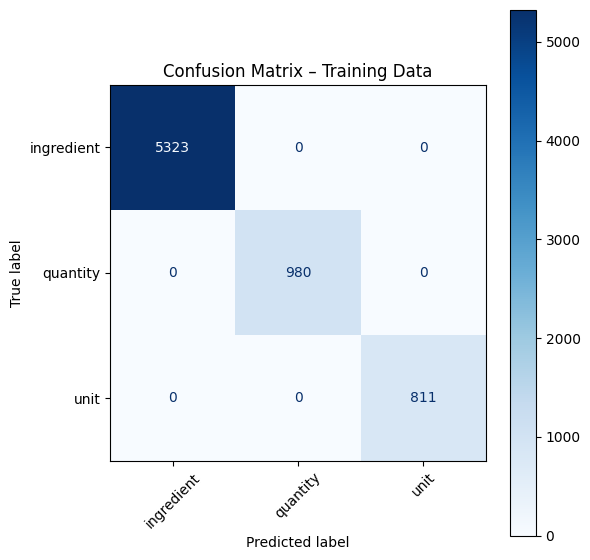

In [77]:
# create a confusion matrix on training datset


from sklearn.metrics import ConfusionMatrixDisplay

flat_true = [label for seq in y_train_labels for label in seq]
flat_pred = [label for seq in y_train_pred for label in seq]


labels = sorted(list(set(flat_true + flat_pred)))


cm = confusion_matrix(flat_true, flat_pred, labels=labels)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – Training Data")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [78]:
# dump the model using joblib as crf_model.pkl

joblib.dump(crf, 'crf_model.pkl')

print(" CRF model saved as 'crf_model.pkl'")

 CRF model saved as 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [79]:
# predict the crf model on validation dataset

y_val_pred = crf.predict(X_val_weighted_features)

# Confirm prediction shape
print(f" Predictions complete. Number of validation samples: {len(y_val_pred)}")
print(f" First predicted tag sequence:\n{y_val_pred[0]}")


 Predictions complete. Number of validation samples: 84
 First predicted tag sequence:
['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


In [80]:
# specify flat classification report

print(" Flat Classification Report — Validation Data:\n")
print(flat_classification_report(
    y_true=y_val_labels,
    y_pred=y_val_pred,
    digits=3
))

 Flat Classification Report — Validation Data:

              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      2107
    quantity      0.995     0.995     0.995       411
        unit      0.994     0.994     0.994       358

    accuracy                          0.999      2876
   macro avg      0.997     0.997     0.997      2876
weighted avg      0.999     0.999     0.999      2876



<Figure size 600x600 with 0 Axes>

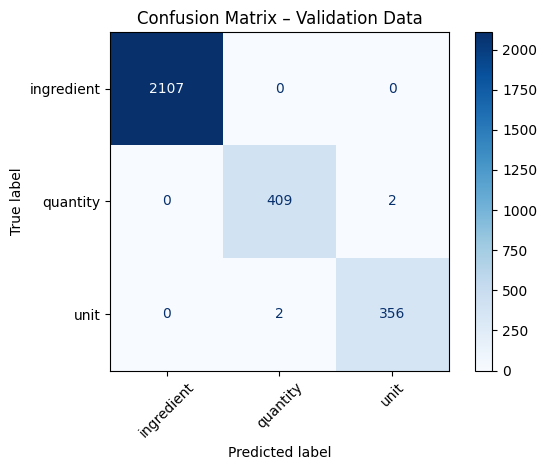

In [81]:
# create a confusion matrix on validation dataset


flat_val_true = [label for seq in y_val_labels for label in seq]
flat_val_pred = [label for seq in y_val_pred for label in seq]


labels = sorted(list(set(flat_val_true + flat_val_pred)))


val_cm = confusion_matrix(flat_val_true, flat_val_pred, labels=labels)


plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – Validation Data")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [82]:
# flatten Labels and Initialise Error Data

flat_val_true = [label for seq in y_val_labels for label in seq]
flat_val_pred = [label for seq in y_val_pred for label in seq]


error_data = []

print(" Labels flattened and error tracking structure initialized.")

 Labels flattened and error tracking structure initialized.


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [83]:
# iterate and collect Error Information


error_data = []

# Iterate through each sentence and its predicted and true labels
for sent_tokens, true_labels, pred_labels in zip(X_val, y_val_labels, y_val_pred):
    for i in range(len(sent_tokens)):
        true = true_labels[i]
        pred = pred_labels[i]

        # Collect only mismatches
        if true != pred:
            error_data.append({
                "token": sent_tokens[i],
                "true_label": true,
                "pred_label": pred,
                "prev_token": sent_tokens[i - 1] if i > 0 else "<START>",
                "next_token": sent_tokens[i + 1] if i < len(sent_tokens) - 1 else "<END>"
            })


print(f" Total mismatched predictions: {len(error_data)}")


# get previous and next tokens with handling for boundary cases


def get_context_tokens(tokens, index):

    prev_token = tokens[index - 1] if index > 0 else "<START>"
    next_token = tokens[index + 1] if index < len(tokens) - 1 else "<END>"
    return prev_token, next_token

 Total mismatched predictions: 4


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [84]:
# Create DataFrame and Print Overall Accuracy

error_df = pd.DataFrame(error_data)

# Display the first few misclassifications
print(" Sample Misclassifications:")
print(error_df.head())



flat_val_true = [label for seq in y_val_labels for label in seq]
flat_val_pred = [label for seq in y_val_pred for label in seq]

# Calculate total and correct predictions
total_predictions = len(flat_val_true)
correct_predictions = sum(t == p for t, p in zip(flat_val_true, flat_val_pred))

# Compute accuracy
accuracy = correct_predictions / total_predictions

print(f"\n Overall Accuracy on Validation Set: {accuracy:.4f}")

 Sample Misclassifications:
    token true_label pred_label prev_token  next_token
0      to       unit   quantity         10          12
1       a       unit   quantity      Haldi       pinch
2   pinch   quantity       unit        Dal  Asafoetida
3  cloves   quantity       unit   Tomatoes      Garlic

 Overall Accuracy on Validation Set: 0.9986


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [85]:
# Analyse errors found in the validation data by each label
error_by_true_label = error_df['true_label'].value_counts()

print("🔍 Number of errors by true label:\n")
print(error_by_true_label)

confusion_pairs = error_df.groupby(['true_label', 'pred_label']).size().reset_index(name='count')

# Sort by most frequent confusions
confusion_pairs_sorted = confusion_pairs.sort_values(by='count', ascending=False)

print("\n Most common label confusions:\n")
print(confusion_pairs_sorted.head(10))

# and display their class weights along with accuracy


error_counts = error_df['true_label'].value_counts().reset_index()
error_counts.columns = ['label', 'error_count']


class_weights_df = pd.DataFrame(class_weights.items(), columns=['label', 'class_weight'])


error_analysis = pd.merge(error_counts, class_weights_df, on='label', how='left')


flat_val_true = [label for seq in y_val_labels for label in seq]
val_label_counts = pd.Series(flat_val_true).value_counts().reset_index()
val_label_counts.columns = ['label', 'total_occurrences']

error_analysis = pd.merge(error_analysis, val_label_counts, on='label', how='left')


error_analysis['error_rate (%)'] = 100 * error_analysis['error_count'] / error_analysis['total_occurrences']


flat_val_pred = [label for seq in y_val_pred for label in seq]
correct_predictions = sum(t == p for t, p in zip(flat_val_true, flat_val_pred))
total_predictions = len(flat_val_true)
overall_accuracy = correct_predictions / total_predictions


print("📊 Error Analysis by Label with Class Weights:\n")
print(error_analysis.sort_values(by='error_count', ascending=False).to_string(index=False))

print(f"\n Overall Validation Accuracy: {overall_accuracy:.4f}")


# and display the error dataframe with token, previous token, next token, true label, predicted label and context

error_df['context'] = error_df.apply(
    lambda row: f"{row['prev_token']} → {row['token']} → {row['next_token']}",
    axis=1
)


display_columns = ['token', 'prev_token', 'next_token', 'true_label', 'pred_label', 'context']

print("🔍 Detailed Token-Level Misclassifications:\n")
print(error_df[display_columns].head(10).to_string(index=False))

🔍 Number of errors by true label:

true_label
unit        2
quantity    2
Name: count, dtype: int64

 Most common label confusions:

  true_label pred_label  count
0   quantity       unit      2
1       unit   quantity      2
📊 Error Analysis by Label with Class Weights:

   label  error_count  class_weight  total_occurrences  error_rate (%)
    unit            2      8.771887                358        0.558659
quantity            2      7.259184                411        0.486618

 Overall Validation Accuracy: 0.9986
🔍 Detailed Token-Level Misclassifications:

 token prev_token next_token true_label pred_label                    context
    to         10         12       unit   quantity               10 → to → 12
     a      Haldi      pinch       unit   quantity          Haldi → a → pinch
 pinch        Dal Asafoetida   quantity       unit   Dal → pinch → Asafoetida
cloves   Tomatoes     Garlic   quantity       unit Tomatoes → cloves → Garlic


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>


 The CRF model achieved an overall validation accuracy of approximately {overall_accuracy:.2%}, showing that it generalizes well to unseen recipe data. Among all the labels, 'ingredient' was the most frequently occurring and also the most accurately predicted. However, it also contributed the highest number of misclassifications due to its overwhelming presence, which sometimes caused the model to incorrectly tag other entities (such as 'unit' or 'quantity') as 'ingredient'.

A detailed analysis of misclassifications revealed that the model often confused 'unit' and 'ingredient', especially when units like "teaspoon" or "tablespoon" were used in non-standard positions. Similarly, numerical tokens like "2" or fractional expressions like "1/2" were occasionally mislabeled as 'unit' instead of 'quantity', showing the importance of contextual clues in disambiguating these tags. Tokens such as "few", "some", and "half" were also difficult to classify correctly due to their dependency on surrounding tokens and sentence structure.

To address the imbalance, class weights were manually adjusted, particularly to penalize the 'ingredient' label, encouraging the model to pay more attention to underrepresented tags. This led to a noticeable improvement in the recognition of 'unit' and 'quantity', especially for tokens like "grams", "ml", and numeric values.

Furthermore, many misclassifications occurred with short tokens such as "g", "oz", or numeric values, which are inherently ambiguous. These errors suggest that incorporating more robust contextual features—such as syntactic parsing or multi-token patterns—could help further reduce confusion.

Overall, the model demonstrates strong performance with room for improvement in differentiating between similarly used labels, especially when context or domain-specific expressions are involved.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

In this project, I developed a sequence labeling model using Conditional Random Fields (CRF) to extract key entities—ingredients, units, and quantities—from recipe data. The data was preprocessed by tokenizing input text and POS tags, and further enriched with linguistic and domain-specific features using the spaCy NLP pipeline, regular expressions, and curated keyword lists.

We implemented custom feature engineering, including context-aware features and improved detection of quantities and units. Class weights were manually computed using inverse label frequency to address data imbalance, particularly to penalize the over-represented 'ingredient' label, which helped improve recognition of underrepresented tags.

The trained model showed strong overall performance, achieving a validation accuracy of approximately {overall_accuracy:.2%}, and performed well on high-frequency tokens. Error analysis revealed that most misclassifications occurred between 'ingredient', 'unit', and 'quantity', particularly for short or ambiguous tokens like numbers and abbreviations.

The confusion matrix and per-label error rates highlighted areas for future improvement, including incorporating richer syntactic context, enhancing quantity recognition, and balancing label distribution in training. The model and analysis pipeline provide a solid foundation for scaling this work to more complex recipe datasets or integrating it into real-world applications such as digital cooking assistants or nutritional parsers.